In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure

In [2]:
#torch.manual_seed(1)

In [3]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
      

        x = self.fc3(x)
        return x

In [6]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt={}
    trainAvgLossArr = []
    trainAvgAccArr = []
    firstParaWgt = {}
    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        totalacc=0

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples
            totalacc += acc

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)
            
            # #Weight Collection
            # if epoch % 3 == 0:
            #     for name, parameter in model.named_parameters():
            #         #print(name)
            #         if'weight' in name:
            #             modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
            #             print(modelParamWgt)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                #print(modelParamWgt)       

        #1st Layer collection
        for name, parameter in model.named_parameters():
            if'fc1' in name and 'weight' in name:
                firstParaWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                #print(firstParaWgt)
                        
        epochLoss = lossSum/(i+1)
        epochAcc = totalacc/(i+1)
        #print("Train Avg loss:",trainAvgLoss)
        trainAvgLossArr.append(epochLoss)    
        trainAvgAccArr.append(epochAcc)
                       
    return train_epoch,train_losses,train_acc,trainAvgLossArr,trainAvgAccArr, modelParamWgt,firstParaWgt

In [7]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [8]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    # scale = StandardScaler()

    # sData = scale.fit_transform(paramDF)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),itr)

    #pcaDf = pd.DataFrame(data = pcaVal, columns = ['x','y'])

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [9]:
a=[]
tempModel = DNN()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total no of parameters:{np.sum(a)}')

Total no of parameters:418060


In [10]:
#2nd Approach

max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]
trainAllacc={}
testAllacc={}
trainAllloss={}
testAllloss={}
train_batch_size = 100
test_batch_size = 100
status_interval = 50
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):
    print("Time: "+str(count))
    M = DNN()
    optimizer = torch.optim.Adam(M.parameters(),lr = 0.0004,weight_decay=1e-4)
    model_name1 = "Times: "+str(count)    
    train_epoch,train_losses,train_acc,trainAvgLoss,trainAvgAccArr, modelParamWgt,firstParamWgt = trainFunc(M,max_epochs,train_batch_size,status_interval)
    testAcc, testLoss = testFunction(M,loss_func,test_batch_size)

    temp_df = pd.DataFrame(modelParamWgt).transpose()
    all_df = all_df.append(temp_df)
    
    firstdf = pd.DataFrame(firstParamWgt).transpose()
    firstLayer = firstLayer.append(firstdf)

    testAllacc[count] = testAcc
    trainAllloss[count] = trainAvgLoss
    testAllloss[count] = testLoss
    trainAllacc[count] = trainAvgAccArr





Time: 0
strated
Time: 1y of the network on the test images: 98.15% & Test Loss: 0.06571345457290591
strated
Time: 2y of the network on the test images: 98.39% & Test Loss: 0.05560417826252888
strated
Time: 3y of the network on the test images: 98.35% & Test Loss: 0.05886246938711338
strated
Time: 4y of the network on the test images: 97.93% & Test Loss: 0.07012845489807659
strated
Time: 5y of the network on the test images: 97.85% & Test Loss: 0.07307451506909274
strated
Time: 6y of the network on the test images: 98.26% & Test Loss: 0.05940908971188946
strated
Time: 7y of the network on the test images: 98.41% & Test Loss: 0.060176715889319894
strated


In [11]:
trainAccArr = []
for key,values in enumerate(trainAllacc):
    trainAccArr.append(trainAllacc[key])
trainLossArr = []
for key,values in enumerate(trainAllloss):
    trainLossArr.append(trainAllloss[key])


In [12]:
    all_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1,0.042618,-0.079695,-0.132603,0.141391,0.094155,0.054628,0.019973,-0.030862,-0.158486,-0.119306,...,-0.154751,0.158411,-0.036216,-0.097887,0.058883,0.127541,-0.029437,-0.061857,-0.150454,0.154191
2,0.041319,-0.080421,-0.143216,0.144437,0.101398,0.058654,0.018079,-0.033759,-0.170310,-0.117109,...,-0.179258,0.172713,-0.041149,-0.103423,0.056786,0.133813,-0.023020,-0.064493,-0.183525,0.160374
3,0.041121,-0.080265,-0.149682,0.148158,0.109886,0.063953,0.016780,-0.035206,-0.180905,-0.116528,...,-0.200783,0.183362,-0.045359,-0.103007,0.057056,0.140751,-0.022543,-0.068790,-0.203034,0.167511
4,0.042162,-0.080711,-0.155917,0.152442,0.117728,0.070296,0.015665,-0.036748,-0.191647,-0.117012,...,-0.224434,0.192368,-0.046921,-0.103830,0.056168,0.146098,-0.024131,-0.075173,-0.221941,0.172559
5,0.041383,-0.084851,-0.158548,0.158070,0.126218,0.076666,0.013749,-0.040403,-0.199173,-0.119974,...,-0.242280,0.202686,-0.048809,-0.103187,0.056859,0.153733,-0.025345,-0.077760,-0.234927,0.179485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,0.245006,-0.093931,-0.642359,0.007472,-0.209081,0.222224,-0.054702,0.125115,-0.124855,-0.425702,...,-0.581995,-0.367888,-0.032187,0.000030,-0.155051,0.237162,0.284512,0.223758,0.430833,-0.061535
42,0.244407,-0.091947,-0.647931,0.004750,-0.213222,0.225568,-0.059998,0.123835,-0.124822,-0.438059,...,-0.586832,-0.370308,-0.031056,0.000019,-0.155783,0.238150,0.283469,0.226987,0.434644,-0.059281
43,0.247426,-0.090802,-0.649212,0.005899,-0.213417,0.227919,-0.059403,0.126348,-0.124107,-0.436659,...,-0.592056,-0.376634,-0.031054,0.000010,-0.157099,0.241640,0.286286,0.231499,0.437476,-0.058549
44,0.249781,-0.091469,-0.656418,0.003991,-0.216347,0.230840,-0.057102,0.127689,-0.128858,-0.437290,...,-0.600138,-0.376636,-0.028595,0.000004,-0.156763,0.247334,0.290197,0.234991,0.443446,-0.059895


In [13]:
train_acc_df = pd.DataFrame(trainAccArr)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')


Shape of Loss:(360,) & Shape of Acc: (360,)


In [14]:
t1 = all_df
print(pd.DataFrame(t1))

         0         1         2         3         4         5         6    \
1   0.042618 -0.079695 -0.132603  0.141391  0.094155  0.054628  0.019973   
2   0.041319 -0.080421 -0.143216  0.144437  0.101398  0.058654  0.018079   
3   0.041121 -0.080265 -0.149682  0.148158  0.109886  0.063953  0.016780   
4   0.042162 -0.080711 -0.155917  0.152442  0.117728  0.070296  0.015665   
5   0.041383 -0.084851 -0.158548  0.158070  0.126218  0.076666  0.013749   
..       ...       ...       ...       ...       ...       ...       ...   
41  0.245006 -0.093931 -0.642359  0.007472 -0.209081  0.222224 -0.054702   
42  0.244407 -0.091947 -0.647931  0.004750 -0.213222  0.225568 -0.059998   
43  0.247426 -0.090802 -0.649212  0.005899 -0.213417  0.227919 -0.059403   
44  0.249781 -0.091469 -0.656418  0.003991 -0.216347  0.230840 -0.057102   
45  0.253308 -0.089558 -0.661606  0.004146 -0.218548  0.234552 -0.056316   

         7         8         9    ...       490       491       492       493  \
1  -0.

In [15]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
# scaling=StandardScaler()
# scaled_data = scaling.fit_transform(new_data)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

allEpochDf


,x,y,Epoch,Iteration,Acc,Loss
0,0.792088,-0.557065,0,0,80.578038,0.444748
1,0.843467,-0.601319,1,0,94.257312,0.183480
2,0.896298,-0.639789,2,0,96.100438,0.129397
3,0.944598,-0.675886,3,0,97.008230,0.097625
4,0.986807,-0.712796,4,0,97.765769,0.077439
...,...,...,...,...,...,...
355,-2.464384,-1.621047,40,7,99.888067,0.006831
356,-2.498115,-1.642499,41,7,99.859960,0.006573
357,-2.519750,-1.658389,42,7,99.990055,0.003443
358,-2.548760,-1.679154,43,7,99.935236,0.006455


In [16]:
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
epoch3Df

,x,y,Epoch,Iteration,Acc,Loss
0,0.896298,-0.639789,2,0,96.100438,0.129397
1,1.029687,-0.747516,5,0,98.092301,0.063141
2,1.151567,-0.849165,8,0,98.960027,0.038365
3,1.271260,-0.949687,11,0,99.456995,0.023880
4,1.390270,-1.045675,14,0,99.731173,0.016444
...,...,...,...,...,...,...
115,-2.212260,-1.457263,32,7,99.922615,0.006271
116,-2.309711,-1.518677,35,7,99.903324,0.008503
117,-2.397899,-1.584403,38,7,99.901840,0.006257
118,-2.498115,-1.642499,41,7,99.859960,0.006573


In [17]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

120

In [18]:
cmap = ['red','blue','purple','green','yellow','brown','black','grey']

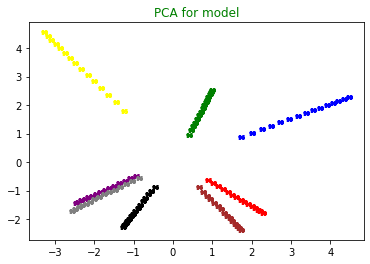

In [28]:
#figure(figsize=(6, 5), dpi=800)
for i in range(len(mv)):
    m = mv[i]
    # colors = epoch3Df ['Iteration'][i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for model",color="g")


plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_1Copy.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()

In [20]:
epoch1stEpoch= allEpochDf.loc[(allEpochDf['Epoch']+1) == 1]
epoch1stEpoch = epoch1stEpoch.reset_index(drop=True)
epoch1stEpoch

,x,y,Epoch,Iteration,Acc,Loss
0,0.792088,-0.557065,0,0,80.578038,0.444748
1,1.516267,0.753354,0,1,79.667475,0.435208
2,-0.804321,-0.407642,0,2,77.102827,0.439516
3,0.375406,0.832277,0,3,78.119713,0.441358
4,-1.066203,1.540160,0,4,79.543449,0.435514
5,0.592574,-0.748622,0,5,78.380482,0.440093
6,-0.399504,-0.759309,0,6,80.226310,0.428526
7,-0.732534,-0.478265,0,7,79.404420,0.443256


In [21]:
test = np.array(epoch1stEpoch.Acc)
fl = []
for i in range(len(test)):
    fl.append(str(int(test[i])))
len(fl)

8

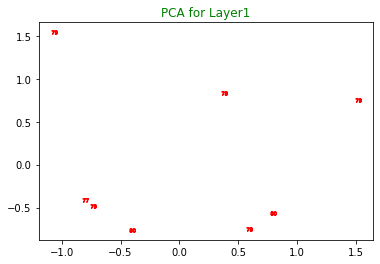

In [22]:
for i in range(len(fl)):
    m = fl[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch1stEpoch['x'][i],epoch1stEpoch['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="g")

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_Layer1.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()

In [23]:
tF = firstdf

tF = np.array(tF)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(tF)

firstLayDf = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

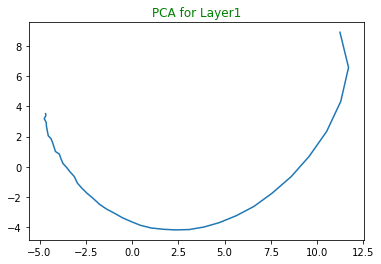

In [24]:
plt.plot(firstLayDf['x'],firstLayDf['y'])
plt.title("PCA for Layer1",color="g")

plt.savefig('D:/Clemson/COURSE/SEM-2/CPSC-8430 Deep Learning - 001/Homework/CPSC-8430-Deep-Learning-001/HW1/plots/PCA_Layer1_2.jpg',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()